# Download essential datasets and packages

Setting up PyTorch Geometry

In [1]:
!pip install energyflow

In [2]:
! nvcc --version
! python -c "import torch; print(torch.version.cuda)"
! python -c "import torch; print(torch.__version__)"
! python -c "import torch; print(torch.cuda.is_available())"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
10.1
1.4.0
True


In [0]:
! PATH=/usr/local/cuda/bin:$PATH
! CPATH=/usr/local/cuda/include:$CPATH    
! LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH
! DYLD_LIBRARY_PATH=/usr/local/cuda/lib:$DYLD_LIBRARY_PATH

In [4]:
! pip install --no-cache-dir torch-scatter==2.0.2
! pip install --no-cache-dir torch-sparse==0.4.4
! pip install --no-cache-dir torch-cluster==1.4.5
! pip install torch-geometric==1.4.1
#! pip install torch-spline-conv==10.1 -f https://pytorch-geometric.com/whl/torch-1.4.0.html

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Load data

In [0]:
import energyflow
X,y = energyflow.qg_jets.load(num_data=100000, generator='pythia', pad=True, with_bc=False, cache_dir='~/.energyflow')

tuple


X of shape (100000,M,4) where 100,000 is the number of jets per file,  M is the max multiplicity of the jets and 4 is the number of features per point cloud (particle). The four features are the 

1. particle’s pt
2. rapidity azimuthal 
3. angle 
4. pdgid

M is multiplicity

Jet multiplicity is the number of jets.

The number of jets can be very interesting depending on the kind of events you want to study. Sometimes the jet multiplicity is part of the event selection

In [6]:
X.shape,y.shape

((100000, 139, 4), (100000,))

Based on a cursory view of the data. We can see the Dimensions of X tensor is (100000,139,4)

1. 100000 pertains to the number of in the dataset - this is like an index
2. 139 pertains to the multipicity of the jets - max number of jets produced in an event 
3. 4 pertains to the particle produced in the event - this describes the chracteristics of the particle produced, such as particle’s pt, rapidity, azimuthal angle and pdgid

Data Modelling Technique

I think we can model the data as such

 1. Graphs - Jets
 2. Nodes - particles 
 3. Edge - I think this is a hidden latent vector (I'm not sure about it) 

 Rushed Science is bad science. But I think we have the right format here

# Test Model

In [0]:
%matplotlib inline

Loaded quark and gluon jets
Done making jet images
Done train/val/test split
Finished preprocessing
Model summary:
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_0 (Conv2D)            (None, 8, 26, 26)         1032      
_________________________________________________________________
activation_11 (Activation)   (None, 8, 26, 26)         0         
_________________________________________________________________
max_pool_0 (MaxPooling2D)    (None, 4, 13, 26)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 10, 23)         520       
_________________________________________________________________
activation_12 (Activation)   (None, 8, 10, 23)         0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 4, 5, 23)          0         
_____

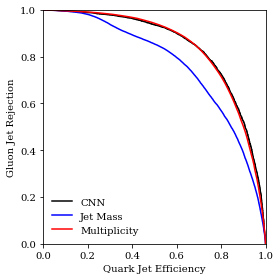

In [0]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import CNN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, pixelate, standardize, to_categorical, zero_center

# attempt to import sklearn
try:
    from sklearn.metrics import roc_auc_score, roc_curve
except:
    print('please install scikit-learn in order to make ROC curves')
    roc_curve = False

# attempt to import matplotlib
try:
    import matplotlib.pyplot as plt
except:
    print('please install matploltib in order to make plots')
    plt = False

################################### SETTINGS ###################################

# data controls
num_data = 100000
val_frac, test_frac = 0.1, 0.15

# image parameters
R = 0.4
img_width = 2*R
npix = 33
nb_chan = 2
norm = True

# required network architecture parameters
input_shape = (nb_chan, npix, npix)
filter_sizes = [8, 4, 4]
num_filters = [8, 8, 8] # very small so can run on non-GPUs in reasonable time

# optional network architecture parameters
dense_sizes = [50]
pool_sizes = 2

# network training parameters
num_epoch = 2
batch_size = 100

################################################################################



# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# make jet images
images = np.asarray([pixelate(x, npix=npix, img_width=img_width, nb_chan=nb_chan, 
                                 charged_counts_only=True, norm=norm) for x in X])

print('Done making jet images')

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(images, Y, val=val_frac, test=test_frac)

print('Done train/val/test split')

# preprocess by zero centering images and standardizing each pixel
X_train, X_val, X_test = standardize(*zero_center(X_train, X_val, X_test))

print('Finished preprocessing')
print('Model summary:')

# build architecture
hps = {'input_shape': input_shape,
       'filter_sizes': filter_sizes,
       'num_filters': num_filters,
       'dense_sizes': dense_sizes,
       'pool_sizes': pool_sizes}
cnn = CNN(hps)

# train model
cnn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

# get predictions on test data
preds = cnn.predict(X_test, batch_size=1000)

# get ROC curve if we have sklearn
if roc_curve:
    cnn_fp, cnn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print()
    print('CNN AUC:', auc)
    print()

    # make ROC curve plot if we have matplotlib
    if plt:

        # get multiplicity and mass for comparison
        masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
        mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
        mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
        mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

        # some nicer plot settings 
        plt.rcParams['figure.figsize'] = (4,4)
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['figure.autolayout'] = True

        # plot the ROC curves
        plt.plot(cnn_tp, 1-cnn_fp, '-', color='black', label='CNN')
        plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
        plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

        # axes labels
        plt.xlabel('Quark Jet Efficiency')
        plt.ylabel('Gluon Jet Rejection')

        # axes limits
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # make legend and show plot
        plt.legend(loc='lower left', frameon=False)
        plt.show()


# Graph Neural Network

In [0]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(4, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


# Data Preparation

Here we are treating the particles as a node and the particle features as edges, for that we have to format the data.

1. I also noticed that many particles features were just 0, therefore I am taking only particles whose mean values of the features is not 0.

In [8]:
import numpy as np
from tqdm import tqdm

graph_X, graph_y = [], []
for jet_stream,label in tqdm(zip(X,y)):
  for jet in jet_stream:
    if np.mean(jet) != 0:
      graph_X.append(jet)
      graph_y.append(label)

100000it [01:25, 1163.38it/s]


In [23]:
from collections import Counter
counter = Counter(graph_y)
counter

Counter({0.0: 2660906, 1.0: 1669999})

# Downsampling data

In [26]:
from imblearn.under_sampling import RandomUnderSampler
print('Original dataset shape %s' % Counter(graph_y))

rus = RandomUnderSampler(random_state=42)
graph_X, graph_y = rus.fit_resample(graph_X, graph_y)
print('Resampled dataset shape %s' % Counter(graph_y))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Original dataset shape Counter({0.0: 2660906, 1.0: 1669999})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampled dataset shape Counter({0.0: 1669999, 1.0: 1669999})


In [27]:
graph_X = np.asarray(graph_X, dtype=np.float32)
graph_y = np.asarray(graph_y, dtype=np.float32)
graph_X.shape,graph_y.shape

((3339998, 4), (3339998,))

# Training Process

In [0]:
from torch_geometric.data import Data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nodes_particles = graph_X.reshape(len(graph_X),4)
nodes_particles = torch.from_numpy(nodes_particles).float().to(device) 

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)

labels = graph_y
labels = torch.from_numpy(labels).long().to(device)

data = Data(x=nodes_particles, edge_index=edge_index, y=labels)

In [0]:

model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, labels)
    loss.backward()
    optimizer.step()

# Evaluation Process 

In [30]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float (pred.eq(labels).sum().item())
acc = correct / labels.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 1.0662


# Graph Neural Network - Massage Passing Neural Network

In [0]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-6: Start propagating messages.
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # Step 6: Return new node embeddings.
        return aggr_out

In [0]:
conv = GCNConv(4, 32).to(device)
output_mp = conv(nodes_particles, edge_index.to(device))

In [0]:
conv.eval()
_, pred = conv(nodes_particles, edge_index.to(device)).max(dim=1)
correct = float (pred.eq(labels).sum().item())
acc = correct / labels.sum().item()